8-mode dataset taken from 'Unrolled GANs': https://openreview.net/forum?id=BydrOIcle

25-mode dataset taken from 'Your GAN is Secretly an Energy-based Model': https://papers.nips.cc/paper/2020/hash/90525e70b7842930586545c6f1c9310c-Abstract.html

# Imports

In [ ]:
# https://github.com/clovaai/generative-evaluation-prdc
!wget -O prdc.py https://raw.githubusercontent.com/clovaai/generative-evaluation-prdc/master/prdc/prdc.py

with open("prdc.py") as f:
    lines = f.readlines()

with open("prdc.py", "w") as f:
    lines.insert(8, "# ")
    f.write("".join(lines))

--2023-07-03 18:03:45--  https://raw.githubusercontent.com/clovaai/generative-evaluation-prdc/master/prdc/prdc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2886 (2.8K) [text/plain]
Saving to: ‘prdc.py’

prdc.py             100%[===================>]   2.82K  --.-KB/s    in 0s      

2023-07-03 18:03:45 (38.6 MB/s) - ‘prdc.py’ saved [2886/2886]



In [ ]:
import itertools
from matplotlib import pyplot as plt
import numpy as np
import prdc
from sklearn.mixture import GaussianMixture as sklearn_GM
from tqdm import tqdm

# GMM Boilerplate

In [ ]:
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_is_fitted

class GaussianMixture(sklearn_GM):

    def sample(self, n_samples=1, uniformly=False):

        check_is_fitted(self)

        if n_samples < 1:
            raise ValueError(
                "Invalid value for 'n_samples': %d . The sampling requires at "
                "least one sample." % (self.n_components)
            )

        _, n_features = self.means_.shape
        rng = check_random_state(self.random_state)
        # Calculate the number of samples per each component
        if uniformly:
            n_samples_comp  = np.ones(self.n_components, dtype=int) * n_samples // self.n_components
            n_samples_comp[rng.choice(self.n_components, size = n_samples % self.n_components, replace=False)] += 1
        else:
            n_samples_comp  = rng.multinomial(n_samples, self.weights_)

        if self.covariance_type == "full":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, covariance, int(sample))
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )
        elif self.covariance_type == "tied":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, self.covariances_, int(sample))
                    for (mean, sample) in zip(self.means_, n_samples_comp)
                ]
            )
        else:
            X = np.vstack(
                [
                    mean
                    + rng.standard_normal(size=(sample, n_features))
                    * np.sqrt(covariance)
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )

        y = np.concatenate(
            [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
        )

        return (X, y)

# Hyperparameters / Initialization

In [ ]:
np.random.seed(0)

In [ ]:
N_MODES = 25
N_INIT_PER_MODE = 100 #25
N_SYNTHETIC = N_MODES * N_INIT_PER_MODE #N_MODES * 100 #500
N_OLD = N_MODES * 0 #N_INIT_PER_MODE
N_NEW = N_MODES * 0

thresh_stddev = 4
thresh_prob = 6.334e-5
thresh_log = np.log(thresh_prob)

if N_MODES == 8:
    # 8 points evenly spaced around a circle of radius 2
    original_means = 2 * np.vstack((np.cos(np.linspace(0, 1.75, 8) * np.pi), np.sin(np.linspace(0, 1.75, 8) * np.pi))).T.round(2)
    var = 0.02**2

if N_MODES == 25:
    original_means = np.array([np.array(v) for v in itertools.product(np.arange(-2, 3, 1), np.arange(-2, 3, 1))])
    var = 0.01


real_gmm = GaussianMixture(n_components=N_MODES)
real_gmm.weights_ = np.ones(N_MODES) / N_MODES
real_gmm.means_ = original_means
real_gmm.covariances_ = np.expand_dims(np.eye(2), axis=0).repeat(N_MODES, axis=0) * var
real_gmm.precisions_  = np.expand_dims(np.eye(2), axis=0).repeat(N_MODES, axis=0) / var
real_gmm.precisions_cholesky_ = np.expand_dims(np.eye(2), axis=0).repeat(N_MODES, axis=0) / np.sqrt(var)


real_data = real_gmm.sample(N_MODES * N_INIT_PER_MODE, uniformly=True)[0]
np.random.shuffle(real_data)

print(np.array([np.outer(m, m) for m in original_means]).mean(axis=0))
print(real_gmm.score_samples(real_data).min())

[[2. 0.]
 [0. 2.]]
-7.289746742414973


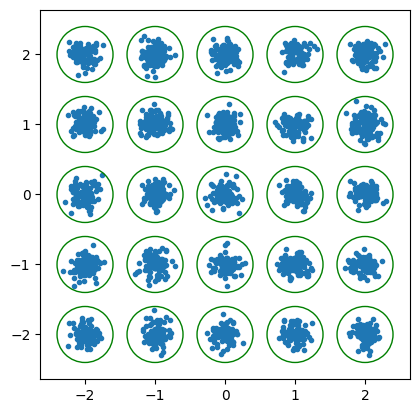

In [ ]:
fig, ax = plt.subplots()
ax.scatter(real_data[:,0], real_data[:,1], marker='.')

# Plotting the estimated manifold:
#for p in range(len(real_data)):
#  cir = plt.Circle(real_data[p], real_nearest_neighbour_distances[p], color='r', fill=False)
#  ax.add_patch(cir)

# Plotting the real manifold (4 standard deviations):
for m in original_means:
  cir = plt.Circle(m, np.sqrt(var) * thresh_stddev, color='green', fill=False)
  ax.add_patch(cir)
ax.set_aspect('equal')
plt.show()

# Training

In [ ]:
sampling_interval = 500 #100 * 2
sqrt = 2 #5 or 6
iters = sampling_interval * sqrt * sqrt

gmm_history = np.zeros(iters, dtype=object)
synthetic_history = np.zeros((iters, N_SYNTHETIC, 2))
if N_NEW > 0:
    new_history = np.zeros((iters, N_NEW, 2))

madc_data = real_data

for i in tqdm(range(iters)):
    gmm = GaussianMixture(n_components=N_MODES)
    gmm.fit(madc_data)
    gmm_history[i] = gmm

    madc_data = gmm.sample(N_SYNTHETIC)[0]
    synthetic_history[i] = madc_data

    if N_OLD > 0:
        madc_data = np.vstack((madc_data, real_data[:N_OLD]))

    if N_NEW > 0:
        new_history[i] = real_gmm.sample(N_NEW, uniformly=True)[0]
        madc_data = np.vstack((madc_data, new_history[i]))

100%|██████████| 2000/2000 [04:54<00:00,  6.78it/s]


# Results: Distributions

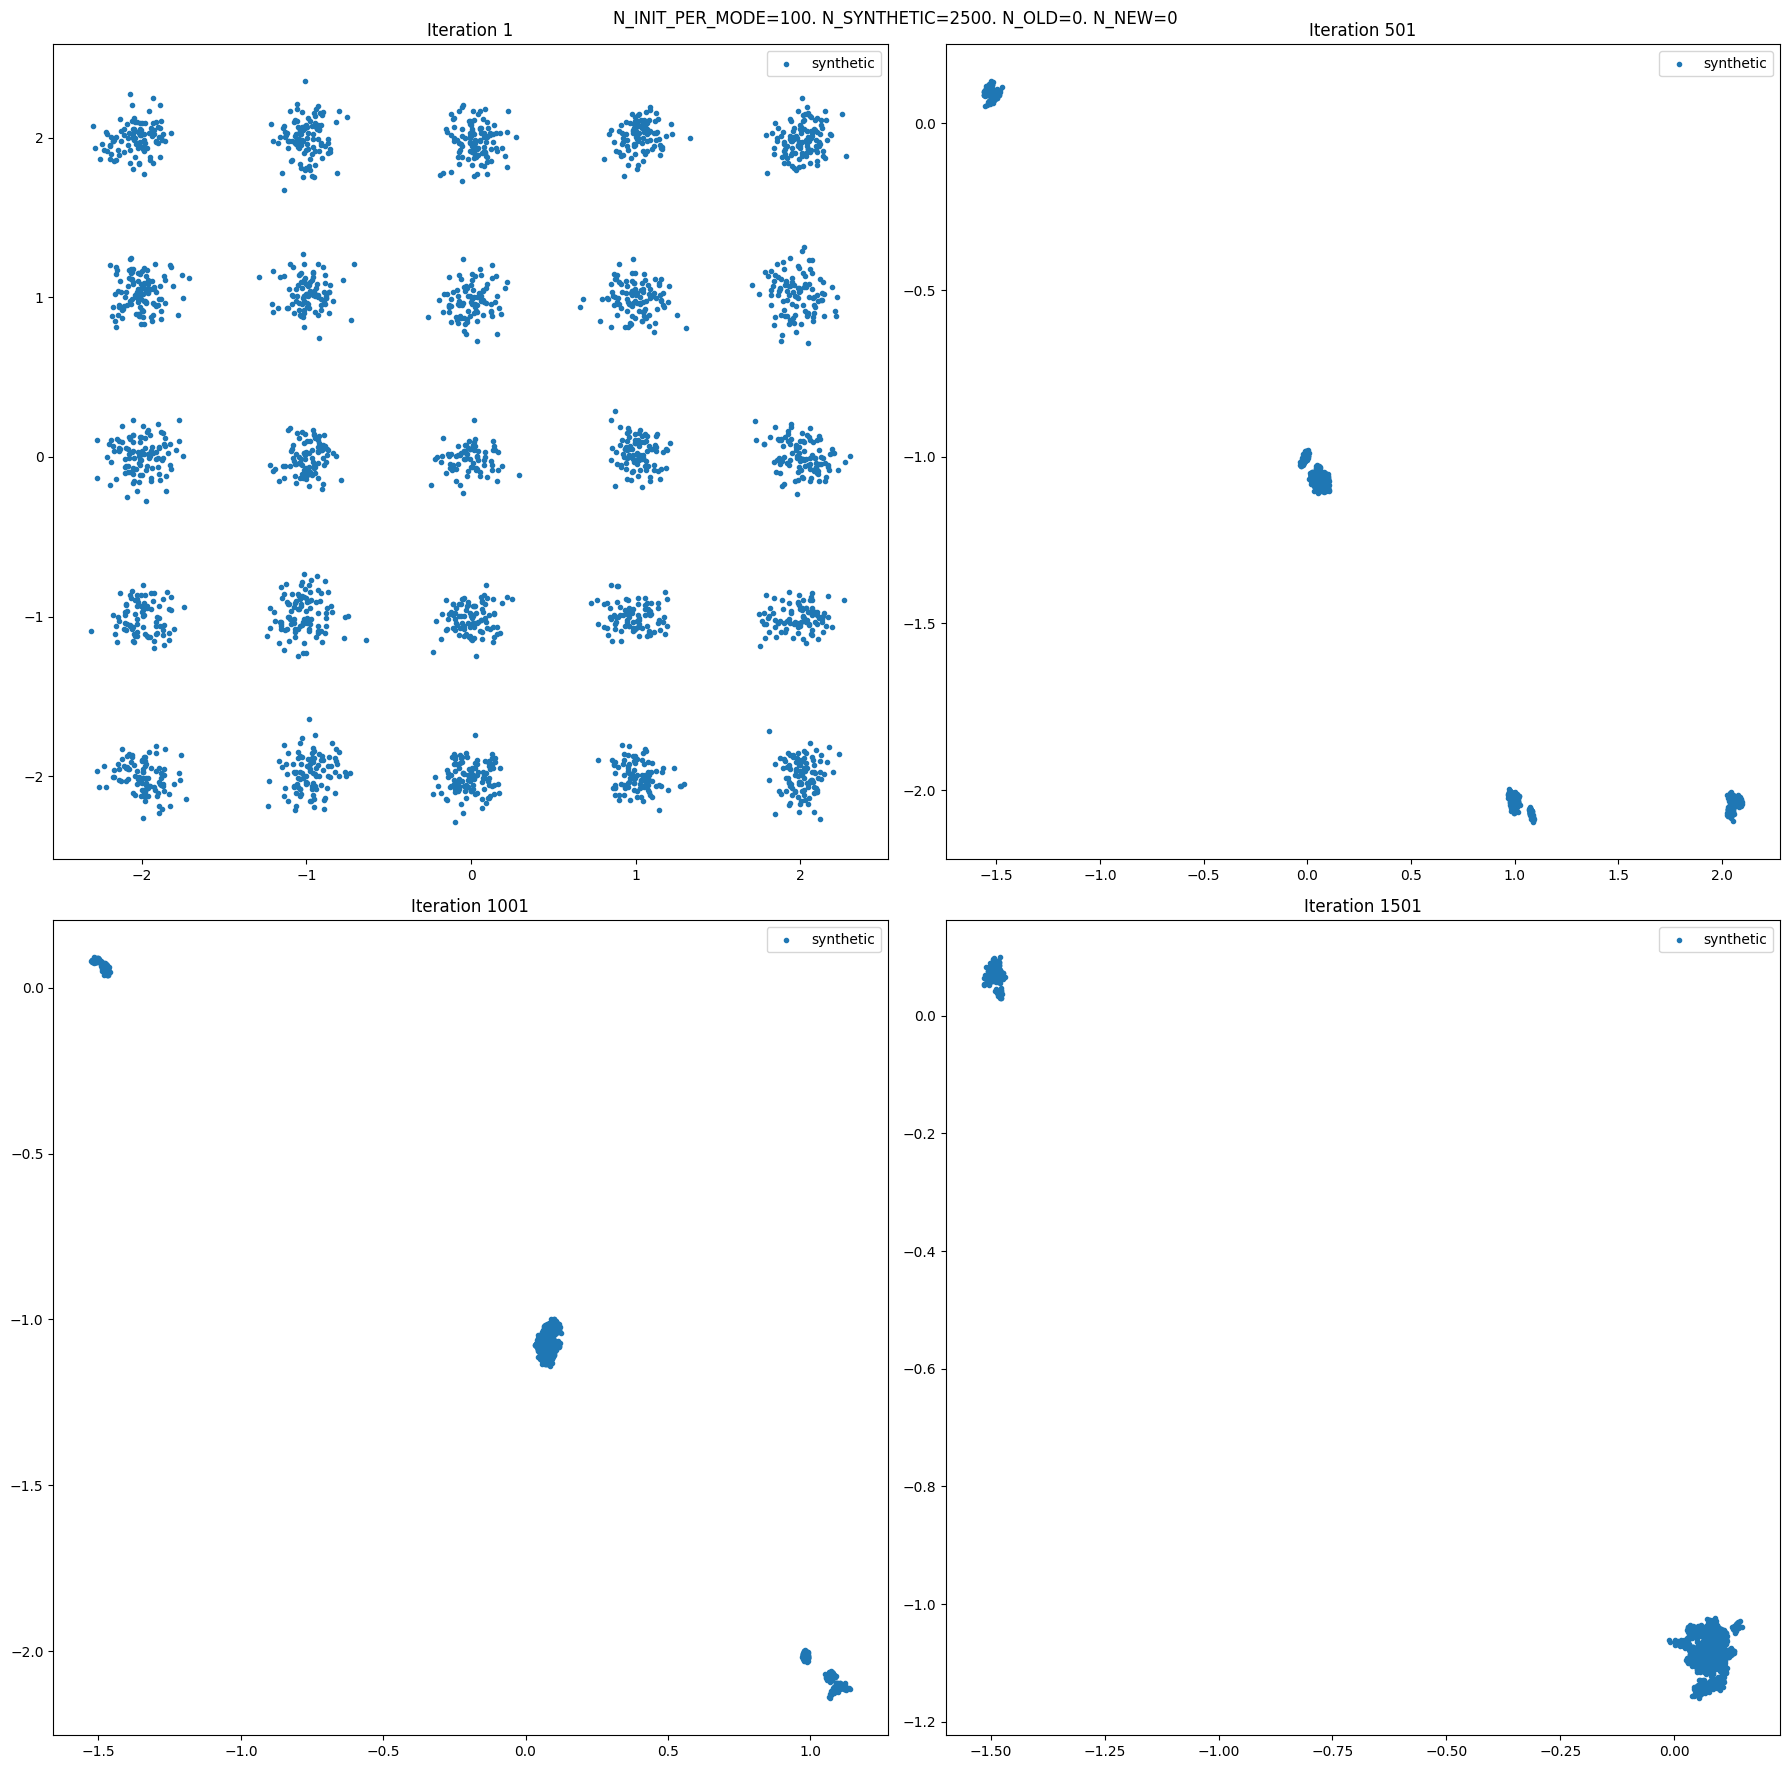

In [ ]:
fig, ax = plt.subplots(ncols=sqrt, nrows=sqrt, figsize=(18,18))

for i in np.arange(0, iters, sampling_interval):
    ax_i = ax[i // sampling_interval // sqrt, i // sampling_interval % sqrt]
    ax_i.scatter(synthetic_history[i, :, 0], synthetic_history[i, :, 1],
                 marker='.', label='synthetic')

    if N_OLD > 0:
        ax_i.scatter(real_data[:N_OLD, 0], real_data[:N_OLD, 1],
                     marker='.', c='orange', label='old real')

    if N_NEW > 0:
        ax_i.scatter(new_history[i, :, 0], new_history[i, :, 1],
                     marker='.', c='r', label='new real')

    ax_i.set_title(f'Iteration {i+1}')
    ax_i.legend()


qualifier = f'{N_INIT_PER_MODE=}. {N_SYNTHETIC=}. {N_OLD=}. {N_NEW=}'
plt.suptitle(qualifier)
plt.tight_layout()

In [ ]:
# Calculate mean and covariance
total_means = np.zeros((iters, 2))
total_covs  = np.zeros((iters, 2, 2))
var_sum = np.zeros(iters)

for i, g in enumerate(gmm_history):
  total_means[i] = np.sum(g.weights_[:,None] * g.means_, axis=0)
  total_covs[i]  = np.sum(g.weights_[:,None,None] * g.covariances_, axis=0)
  var_sum[i] = total_covs[i].trace()
  total_covs[i] += np.sum(g.weights_[:,None,None] * np.array([np.outer(m, m) for m in g.means_]), axis=0)
  total_covs[i] -= np.outer(total_means[i], total_means[i])

total_var = np.trace(total_covs, axis1=1, axis2=2)

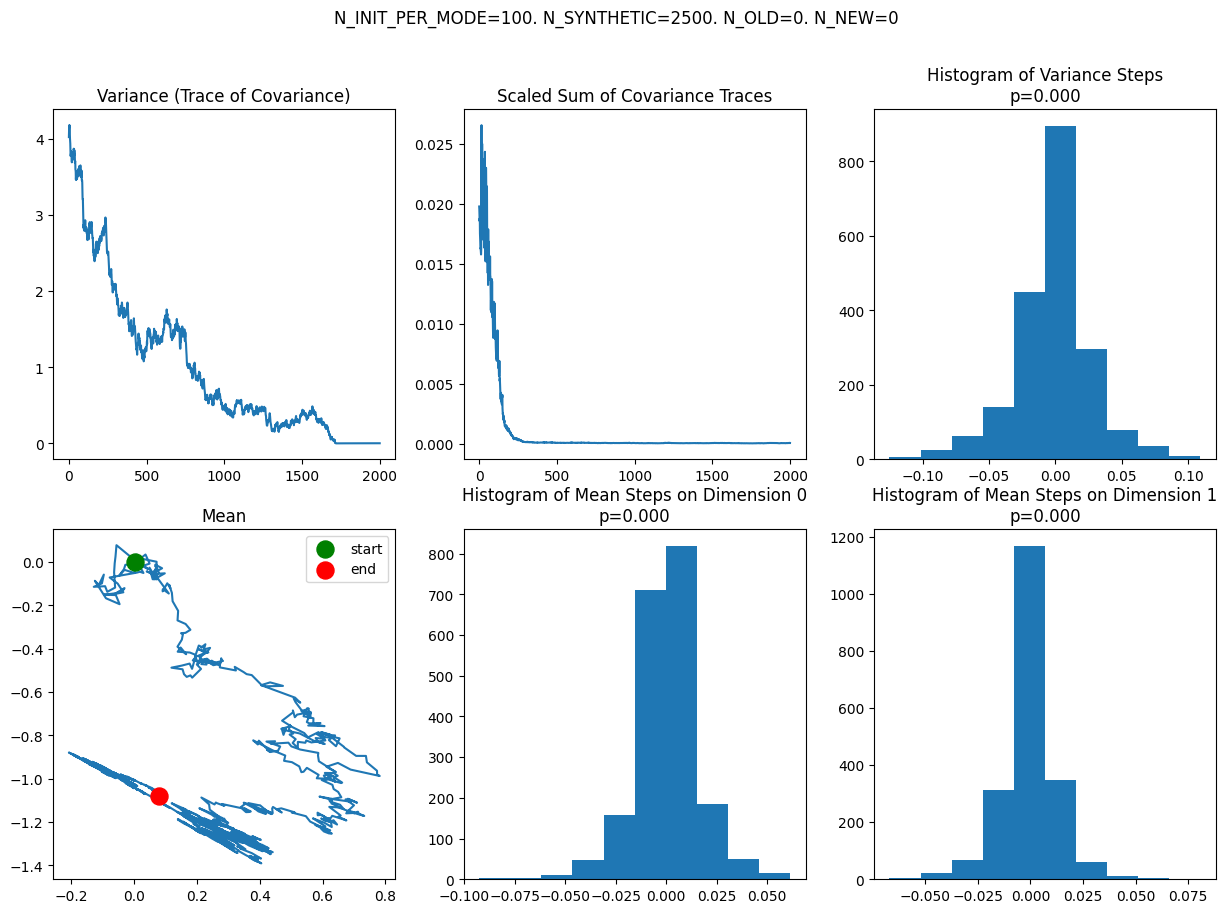

In [ ]:
import scipy.stats as stats

def xaxis_wrt_generation(axis):
    axis.set_xlabel('Number of Generations')
    axis.set_xticklabels([int(item.get_text().replace('−', '-')) + 1
                          for item in axis.get_xticklabels()])


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
ax[0,0].plot(total_var)
ax[0,0].set_title('Variance (Trace of Covariance)')

ax[0,1].plot(var_sum)
ax[0,1].set_title('Scaled Sum of Covariance Traces')

ax[0,2].hist(np.diff(total_var))
ax[0,2].set_title(f'Histogram of Variance Steps\np={stats.shapiro(np.diff(total_var)).pvalue :.3f}')

ax[1,0].plot(total_means[:, 0], total_means[:, 1])
ax[1,0].scatter(total_means[0,0], total_means[0,1], c='green', s=150, zorder=10, label='start')
ax[1,0].scatter(total_means[-1,0], total_means[-1,1], c='red', s=150, zorder=10, label='end')
ax[1,0].legend()
ax[1,0].set_title('Mean')

ax[1,1].hist(np.diff(total_means[:,0]))
ax[1,1].set_title(f'Histogram of Mean Steps on Dimension 0\np={stats.shapiro(np.diff(total_means[:,0])).pvalue :.3f}')

ax[1,2].hist(np.diff(total_means[:,1]))
ax[1,2].set_title(f'Histogram of Mean Steps on Dimension 1\np={stats.shapiro(np.diff(total_means[:,1])).pvalue :.3f}')

plt.suptitle(qualifier);

In [ ]:
# stats.probplot(np.diff(total_means[:,1]), plot=plt)

# Results: Likelihood + PRDC

In [ ]:
synthetic_ll = np.zeros((iters, N_SYNTHETIC))

for i in tqdm(range(iters)):
    synthetic_ll[i] = real_gmm.score_samples(synthetic_history[i])

100%|██████████| 2000/2000 [00:10<00:00, 192.38it/s]


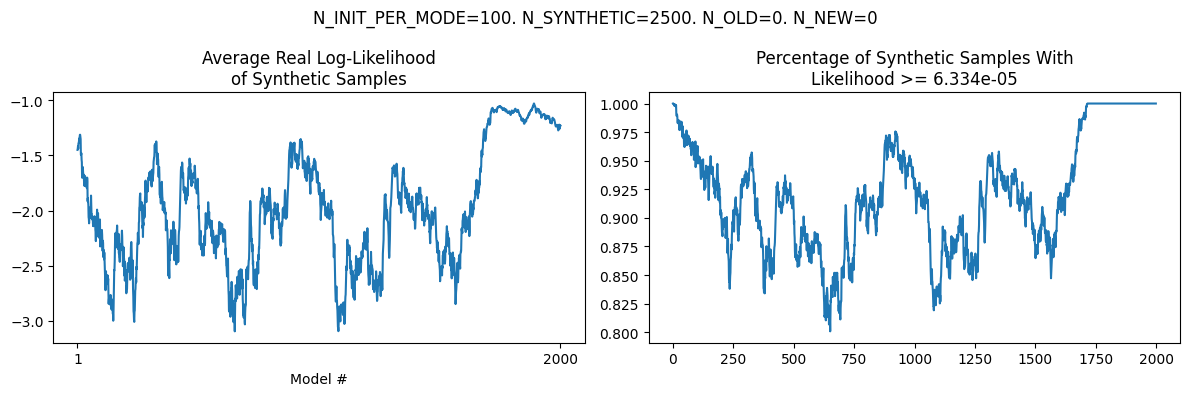

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ax[0].plot(synthetic_ll.mean(axis=1))
ax[0].set_title(f'Average Real Log-Likelihood\nof Synthetic Samples')
ax[0].set_xlabel('Model #')
ax[0].set_xticks([0, iters-1], labels=[1, iters])

ax[1].plot((synthetic_ll > thresh_log).mean(axis=1))
ax[1].set_title(f'Percentage of Synthetic Samples With\nLikelihood >= {thresh_prob}')
ax[0].set_xlabel('Model #')
ax[0].set_xticks([0, iters-1], labels=[1, iters])

plt.suptitle(qualifier)
plt.tight_layout()

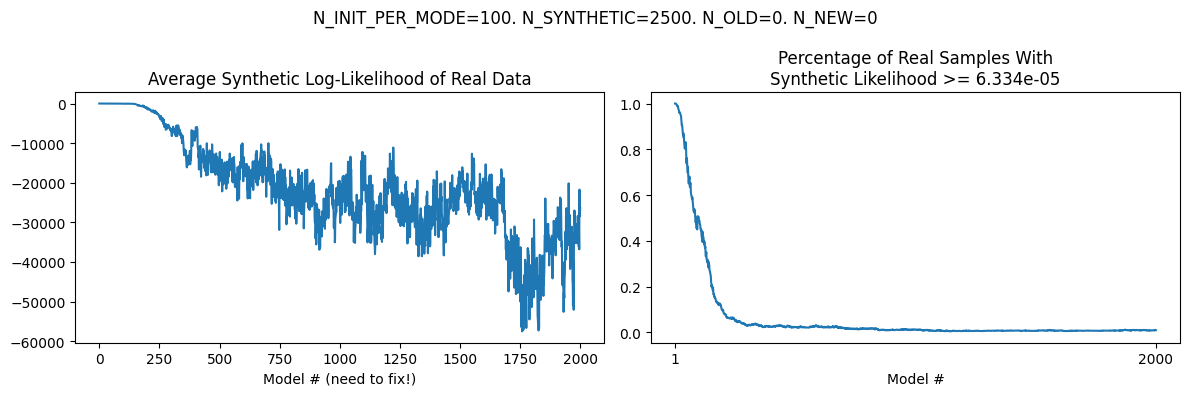

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

real_ll = np.array([g.score_samples(real_data) for g in gmm_history])
ax[0].plot(real_ll.mean(axis=1))
ax[0].set_title('Average Synthetic Log-Likelihood of Real Data')
ax[0].set_xlabel('Model # (need to fix!)')

# Plotting bits per dimension:
'''
ax[1].plot(-ll / 2 / np.log(2))
ax[1].set_title('Bits Per Dimension (scaled NLL) of Real Data')
ax[1].set_xlabel('Model # (need to fix!)')
'''

ax[1].plot((real_ll > thresh_log).mean(axis=1))
ax[1].set_title(f'Percentage of Real Samples With\nSynthetic Likelihood >= {thresh_prob}')
ax[1].set_xlabel('Model #')
ax[1].set_xticks([0, iters-1], labels=[1, iters])

plt.suptitle(qualifier)
plt.tight_layout()

In [ ]:
# Calculate Precision and Recall
precision = np.zeros(iters)
recall = np.zeros(iters)

nearest_k = 3
real_nearest_neighbour_distances = prdc.compute_nearest_neighbour_distances(real_data, nearest_k)

for i in tqdm(range(iters)):
    fake_nearest_neighbour_distances = prdc.compute_nearest_neighbour_distances(synthetic_history[i], nearest_k)
    distance_real_fake = prdc.compute_pairwise_distance(real_data, synthetic_history[i])

    precision[i] = (
            distance_real_fake <
            np.expand_dims(real_nearest_neighbour_distances, axis=1)
    ).any(axis=0).mean()

    recall[i] = (
            distance_real_fake <
            np.expand_dims(fake_nearest_neighbour_distances, axis=0)
    ).any(axis=1).mean()

100%|██████████| 2000/2000 [11:44<00:00,  2.84it/s]


In [ ]:
# Calculate Density and Coverage
density = np.zeros(iters)
coverage = np.zeros(iters)

nearest_k = 5
real_nearest_neighbour_distances = prdc.compute_nearest_neighbour_distances(real_data, nearest_k)

for i in tqdm(range(iters)):
    distance_real_fake = prdc.compute_pairwise_distance(real_data, synthetic_history[i])

    density[i] = (1. / float(nearest_k)) * (
            distance_real_fake <
            np.expand_dims(real_nearest_neighbour_distances, axis=1)
    ).sum(axis=0).mean()

    coverage[i] = (
            distance_real_fake.min(axis=1) <
            real_nearest_neighbour_distances
    ).mean()

100%|██████████| 2000/2000 [05:20<00:00,  6.23it/s]


In [ ]:
# Calculate relative recall and coverage
# In GMMs, however, we see our model of recall = cumprod(relative_recall) does not seem to hold.

'''
relative_recall = np.zeros(iters)
nearest_k = 3

nn_distances = [prdc.compute_nearest_neighbour_distances(syn_hist, nearest_k) for syn_hist in synthetic_history]

for i in tqdm(range(iters)):
    prev_data    = synthetic_history[i-1] if i > 0 else real_data
    prev_nn_dist = nn_distances[i-1]      if i > 0 else prdc.compute_nearest_neighbour_distances(real_data, nearest_k)
    fake_nearest_neighbour_distances = nn_distances[i]
    distance_real_fake = prdc.compute_pairwise_distance(prev_data, synthetic_history[i])

    relative_recall[i] = (
            distance_real_fake <
            np.expand_dims(fake_nearest_neighbour_distances, axis=0)
    ).any(axis=1).mean()


relative_coverage = np.zeros(iters)
nearest_k = 5

for i in tqdm(range(iters)):
    prev_data = real_data if i == 0 else synthetic_history[i-1]
    real_nearest_neighbour_distances = prdc.compute_nearest_neighbour_distances(prev_data, nearest_k)
    distance_real_fake = prdc.compute_pairwise_distance(prev_data, synthetic_history[i])

    relative_coverage[i] = (
            distance_real_fake.min(axis=1) <
            real_nearest_neighbour_distances
    ).mean()
''';

Text(0.5, 0.98, 'N_INIT_PER_MODE=100. N_SYNTHETIC=2500. N_OLD=0. N_NEW=0')

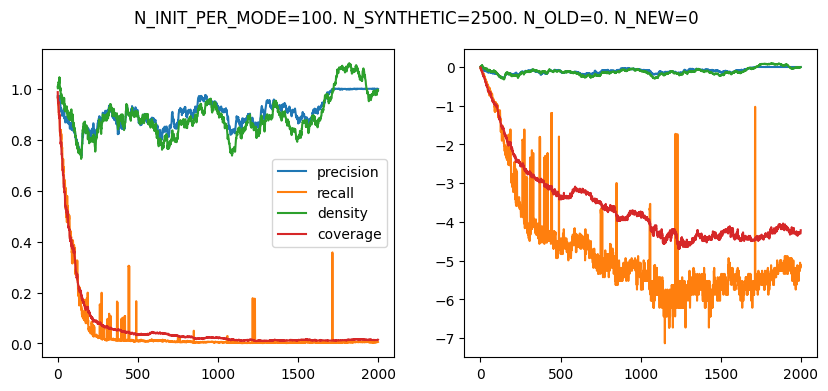

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))

ax[0].plot(precision, label='precision')
ax[0].plot(recall, label='recall')
ax[0].plot(density, label='density')
ax[0].plot(coverage, label='coverage')
ax[0].legend()

ax[1].plot(np.log(precision), label='log-precision')
ax[1].plot(np.log(recall), label='log-recall')
ax[1].plot(np.log(density), label='log-density')
ax[1].plot(np.log(coverage), label='log-coverage')

plt.suptitle(qualifier)

# Giant Metrics Plot

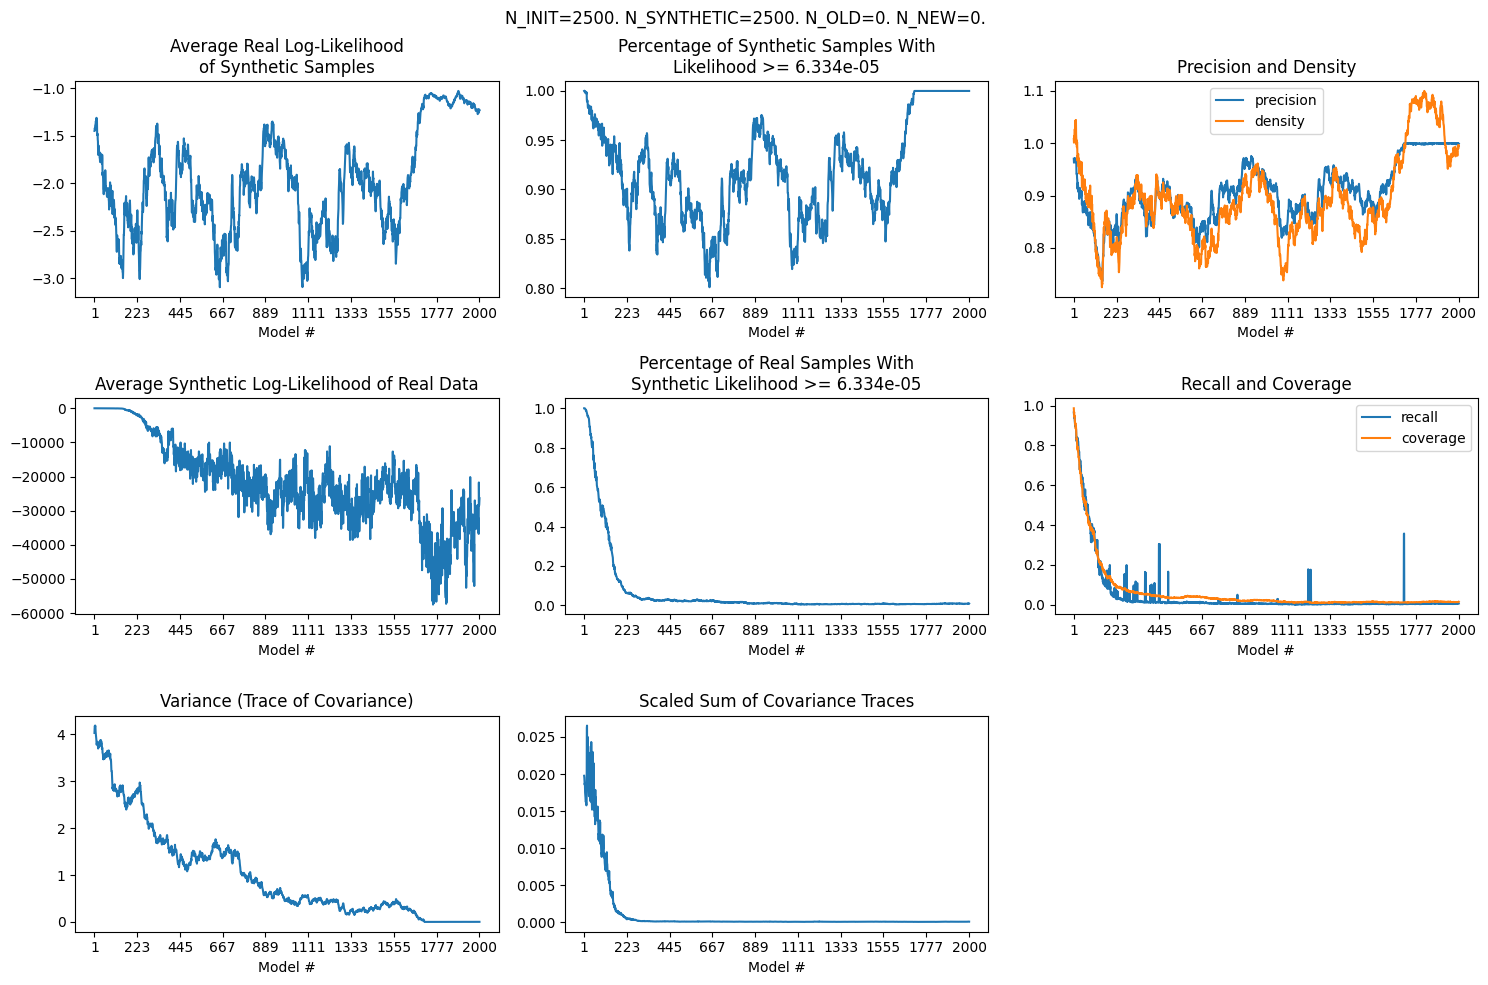

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

ax[0,0].plot(synthetic_ll.mean(axis=1))
ax[0,0].set_title(f'Average Real Log-Likelihood\nof Synthetic Samples')

ax[0,1].plot((synthetic_ll > thresh_log).mean(axis=1))
ax[0,1].set_title(f'Percentage of Synthetic Samples With\nLikelihood >= {thresh_prob}')

ax[0,2].plot(precision, label='precision')
ax[0,2].plot(density, label='density')
ax[0,2].set_title('Precision and Density')
ax[0,2].legend()

ax[1,0].plot(real_ll.mean(axis=1))
ax[1,0].set_title('Average Synthetic Log-Likelihood of Real Data')

ax[1,1].plot((real_ll > thresh_log).mean(axis=1))
if N_OLD > 0:
    ax[1,1].plot([N_OLD / N_INIT_PER_MODE / N_MODES] * iters, '--', c='r', label='N_OLD / N_INIT')
    ax[1,1].legend()
ax[1,1].set_title(f'Percentage of Real Samples With\nSynthetic Likelihood >= {thresh_prob}')

ax[1,2].plot(recall, label='recall')
ax[1,2].plot(coverage, label='coverage')
if N_OLD > 0:
    ax[1,2].plot([N_OLD / N_INIT_PER_MODE / N_MODES] * iters, '--', c='r', label='N_OLD / N_INIT')
ax[1,2].legend()
ax[1,2].set_title('Recall and Coverage')

ax[2,0].plot(total_var)
ax[2,0].set_title('Variance (Trace of Covariance)')

ax[2,1].plot(var_sum)
ax[2,1].set_title('Scaled Sum of Covariance Traces')

fig.delaxes(ax[2,2])

for axis in ax.flatten():
    axis.set_xlabel('Model #')
    x_labels = np.linspace(1, iters, 10).astype(int)
    axis.set_xticks(x_labels-1, labels=x_labels)

plt.suptitle(f'N_INIT={N_INIT_PER_MODE*N_MODES}. {N_SYNTHETIC=}. {N_OLD=}. {N_NEW=}.')
plt.tight_layout()

# Figures for the Paper (Old)

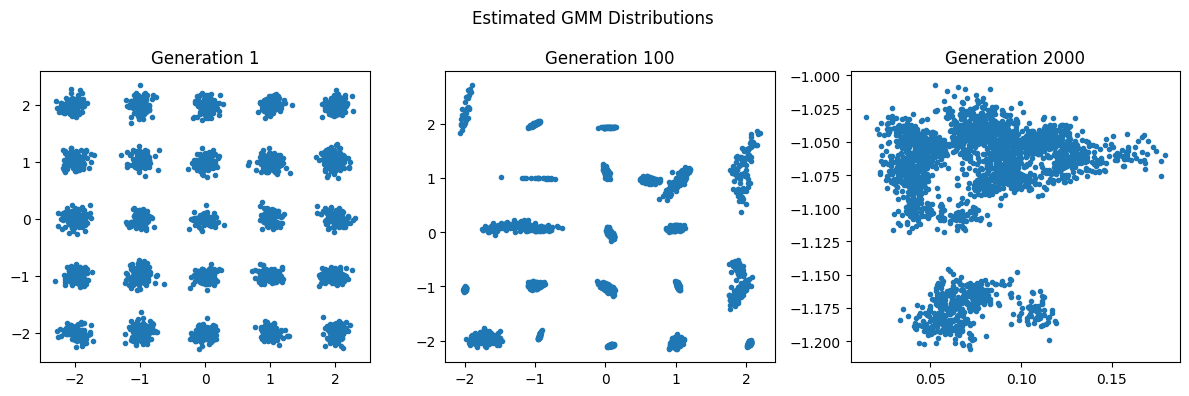

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

for num, i in enumerate([0, 99, iters-1]):
    ax_i = ax[num]
    ax_i.scatter(synthetic_history[i, :, 0], synthetic_history[i, :, 1],
                 marker='.', label='synthetic')

    if N_OLD > 0:
        ax_i.scatter(real_data[:N_OLD, 0], real_data[:N_OLD, 1],
                     marker='.', c='orange', label='old real')

    if N_NEW > 0:
        ax_i.scatter(new_history[i, :, 0], new_history[i, :, 1],
                     marker='.', c='r', label='new real')

    ax_i.set_title(f'Generation {i+1}')
    if N_OLD + N_NEW > 0:
      ax_i.legend()


fig.suptitle('Estimated GMM Distributions ' + ('With Old ' if N_OLD > 0 else '') + ('and New ' if N_NEW > 0 else '') + ('Data' if N_OLD + N_NEW > 0 else ''))
fig.tight_layout()

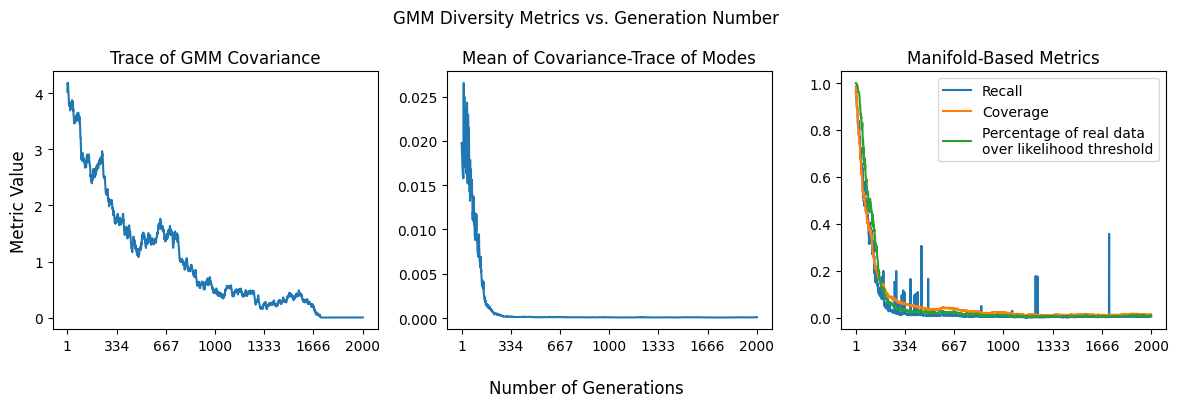

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax[0].plot(total_var)
ax[0].set_title('Trace of GMM Covariance')

ax[1].plot(var_sum)
ax[1].set_title('Mean of Covariance-Trace of Modes')

ax[2].plot(recall, label='Recall')
ax[2].plot(coverage, label='Coverage')
ax[2].plot((real_ll > thresh_log).mean(axis=1), label='Percentage of real data\nover likelihood threshold')
if N_OLD > 0:
    ax[2].plot([N_OLD / N_INIT_PER_MODE / N_MODES] * iters, label='Percentage of initial\nreal data kept')
ax[2].legend()
ax[2].set_title('Manifold-Based Metrics')

fig.suptitle('GMM Diversity Metrics vs. Generation Number')
fig.supxlabel('Number of Generations')
fig.supylabel('Metric Value')

for axis in ax.flatten():
    #axis.set_xlabel('Model #')
    x_labels = np.linspace(1, iters, 7).astype(int)
    axis.set_xticks(x_labels-1, labels=x_labels)

plt.tight_layout()
plt.show()

In [ ]:
if N_OLD > 0:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    ax[0].plot(recall, label='Recall')
    ax[0].plot(coverage, label='Coverage')
    ax[0].plot((real_ll > thresh_log).mean(axis=1), label='Percentage of real data\nover likelihood threshold')
    if N_OLD > 0:
        ax[0].plot([N_OLD / N_INIT_PER_MODE / N_MODES] * iters, 'r--', label='Percentage of initial\nreal data kept')
    ax[0].legend()
    ax[0].set_ylabel('Metric Value')
    ax[0].set_title('Recall and Coverage')
    xaxis_wrt_generation(ax[0])

    ax[1].plot(np.log(recall), label='Log-recall')
    ax[1].plot(np.log(coverage), label='Log-coverage')
    if N_OLD > 0:
        ax[1].plot([np.log(N_OLD / N_INIT_PER_MODE / N_MODES)] * iters, 'r--', label='Log-percentage of initial\nreal data kept')
    ax[1].set_title('Log-recall and Log-coverage')
    ax[1].legend()
    ax[1].set_ylabel('Log-value')
    xaxis_wrt_generation(ax[1])


    fig.suptitle('GMM Recall and Coverage vs. Generation Number ' + ('With Old ' if N_OLD > 0 else '') + ('and New ' if N_NEW > 0 else '') + ('Data' if N_OLD + N_NEW > 0 else ''))
    fig.tight_layout()

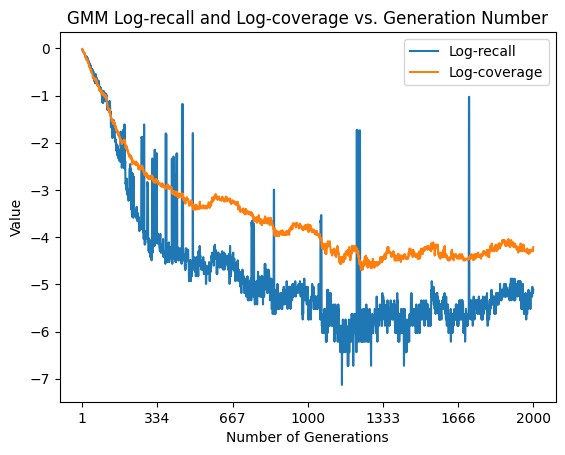

In [ ]:
plt.plot(np.log(recall), label='Log-recall')
plt.plot(np.log(coverage), label='Log-coverage')
plt.title('GMM Log-recall and Log-coverage vs. Generation Number')
plt.legend()
plt.ylabel('Value')
plt.xticks(x_labels-1, labels=x_labels)
plt.xlabel('Number of Generations')

plt.show()

Shapiro-Wilk Normality Test Results:
Dimension 0: p=0.000
Dimension 1: p=0.000


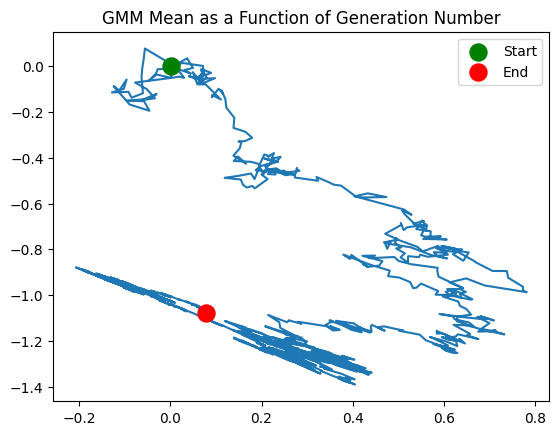

In [ ]:
plt.plot(total_means[:, 0], total_means[:, 1])
plt.scatter(total_means[0,0], total_means[0,1], c='green', s=150, zorder=10, label='Start')
plt.scatter(total_means[-1,0], total_means[-1,1], c='red', s=150, zorder=10, label='End')
plt.legend()
plt.title('GMM Mean as a Function of Generation Number')

print('Shapiro-Wilk Normality Test Results:')
print(f'Dimension 0: p={stats.shapiro(np.diff(total_means[:,0])).pvalue :.3f}')
print(f'Dimension 1: p={stats.shapiro(np.diff(total_means[:,1])).pvalue :.3f}')

Shapiro-Wilk Normality Test Results:
Dimension 0: p=0.000
Dimension 1: p=0.000


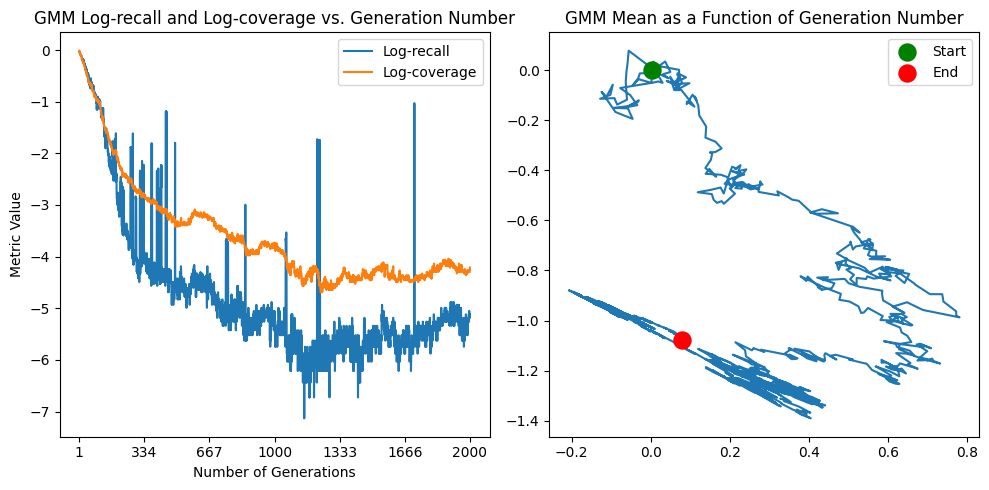

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(np.log(recall), label='Log-recall')
ax[0].plot(np.log(coverage), label='Log-coverage')
ax[0].set_title('GMM Log-recall and Log-coverage vs. Generation Number')
ax[0].legend()
ax[0].set_ylabel('Metric Value')
ax[0].set_xticks(x_labels-1, labels=x_labels)
ax[0].set_xlabel('Number of Generations')


ax[1].plot(total_means[:, 0], total_means[:, 1])
ax[1].scatter(total_means[0,0], total_means[0,1], c='green', s=150, zorder=10, label='Start')
ax[1].scatter(total_means[-1,0], total_means[-1,1], c='red', s=150, zorder=10, label='End')
plt.legend()
ax[1].set_title('GMM Mean as a Function of Generation Number')

print('Shapiro-Wilk Normality Test Results:')
print(f'Dimension 0: p={stats.shapiro(np.diff(total_means[:,0])).pvalue :.3f}')
print(f'Dimension 1: p={stats.shapiro(np.diff(total_means[:,1])).pvalue :.3f}')

fig.tight_layout()

In [ ]:
[print(f'{i+1}, {r:.2f}, 0.1') for i,r in enumerate(recall)];

1, 0.97, 0.1
2, 0.95, 0.1
3, 0.94, 0.1
4, 0.94, 0.1
5, 0.94, 0.1
6, 0.92, 0.1
7, 0.91, 0.1
8, 0.90, 0.1
9, 0.90, 0.1
10, 0.90, 0.1
11, 0.89, 0.1
12, 0.89, 0.1
13, 0.88, 0.1
14, 0.84, 0.1
15, 0.83, 0.1
16, 0.82, 0.1
17, 0.84, 0.1
18, 0.81, 0.1
19, 0.81, 0.1
20, 0.83, 0.1
21, 0.84, 0.1
22, 0.80, 0.1
23, 0.82, 0.1
24, 0.82, 0.1
25, 0.79, 0.1
26, 0.78, 0.1
27, 0.76, 0.1
28, 0.77, 0.1
29, 0.77, 0.1
30, 0.74, 0.1
31, 0.73, 0.1
32, 0.68, 0.1
33, 0.71, 0.1
34, 0.69, 0.1
35, 0.72, 0.1
36, 0.68, 0.1
37, 0.67, 0.1
38, 0.69, 0.1
39, 0.63, 0.1
40, 0.66, 0.1
41, 0.64, 0.1
42, 0.62, 0.1
43, 0.64, 0.1
44, 0.60, 0.1
45, 0.63, 0.1
46, 0.64, 0.1
47, 0.59, 0.1
48, 0.56, 0.1
49, 0.53, 0.1
50, 0.61, 0.1
51, 0.54, 0.1
52, 0.55, 0.1
53, 0.51, 0.1
54, 0.53, 0.1
55, 0.50, 0.1
56, 0.54, 0.1
57, 0.52, 0.1
58, 0.48, 0.1
59, 0.54, 0.1
60, 0.58, 0.1
61, 0.52, 0.1
62, 0.50, 0.1
63, 0.54, 0.1
64, 0.53, 0.1
65, 0.53, 0.1
66, 0.51, 0.1
67, 0.49, 0.1
68, 0.50, 0.1
69, 0.51, 0.1
70, 0.48, 0.1
71, 0.50, 0.1
72, 0.49, 0.1
7

# Data for the Paper

In [ ]:
import pandas as pd

metrics = pd.DataFrame({
    'cov_trace': pd.Series(total_var),
    'mean_mode_trace': pd.Series(var_sum),
    'recall': pd.Series(recall),
    'precision': pd.Series(precision)
})

metrics.to_csv('gmm_fully_synthetic.csv')

# Scatterplots for the Paper

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

# Set the style for seaborn and matplotlib
sns.set_style('whitegrid')
font = {'family': 'serif', 'style': 'normal', 'size': 10}
matplotlib.rc('font', **font)
sfmt = matplotlib.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))
matplotlib.use('Agg')


def create_scatter_plot(X, lim=3.5, s=0.5, alpha=0.3):
    """
    Create a scatter plot from random data.

    Inputs:
        X - a 2D numpy array of shape (2, number of data points).

    Returns:
        None
    """
    # Create a figure and axis object
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # Plot the scatter plot
    ax.scatter(
        X[0, :],
        X[1, :],
        s=s,
        color='#000000',
        alpha=alpha,
    )

    # Set the x and y limits
    ax.set_xlim([-lim, lim])
    ax.set_ylim([-lim, lim])

    # Disable grid lines
    ax.grid(False)

    # Set the title of the plot
    ax.set_title('Scatter plot')

    # Save the plot as an image
    plt.savefig('scatter_plot.png',
                format='png',
                bbox_inches='tight',
                dpi=400,
                pad_inches=.02)

    # Close the figure
    plt.close(fig)


fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

#0, iters//10, iters - 1
i = 100 #iters - 1

create_scatter_plot(synthetic_history[i].T, lim=2.5, s=5, alpha=1)